# ChemROAR Demo Notebook

In [1]:
import transformers
import deepchem as dc
import pandas as pd
import torch
import ROAR
from utils import make_binary_plot
from rdkit.Chem import MolFromSmiles, Draw
import matplotlib.pyplot as plt

No normalization for SPS. Feature removed!
No normalization for AvgIpc. Feature removed!
No normalization for NumAmideBonds. Feature removed!
No normalization for NumAtomStereoCenters. Feature removed!
No normalization for NumBridgeheadAtoms. Feature removed!
No normalization for NumHeterocycles. Feature removed!
No normalization for NumSpiroAtoms. Feature removed!
No normalization for NumUnspecifiedAtomStereoCenters. Feature removed!
No normalization for Phi. Feature removed!
2025-03-08 23:14:26.764516: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-08 23:14:28.057241: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/opt/conda/lib/python3.11/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'lightning'
Skipped loading some Jax models, missing a dependency. No module named 'haiku'


## Function to load various sample molecule datasets. 
## We will use the HIV dataset which contains molecules which either do or do not inhibit HIV replication

In [2]:
def load_dataset(name, return_smiles=True):
    if name == "bace_regression":
        d = dc.molnet.load_bace_regression(splitter=None, featurizer="ECFP")[1][0].to_dataframe()
    elif name == "clearance":
        d = dc.molnet.load_clearance(splitter=None, featurizer="ECFP")[1][0].to_dataframe()
    elif name == "delaney":
        d = dc.molnet.load_delaney(splitter=None, featurizer="ECFP")[1][0].to_dataframe()
    elif name == "lipo":
        d = dc.molnet.load_lipo(splitter=None, featurizer="ECFP")[1][0].to_dataframe()
    elif name == "freesolv":
        d = dc.molnet.load_freesolv(splitter=None, featurizer="ECFP")[1][0].to_dataframe()
    elif name == "sider":
        d = dc.molnet.load_sider(splitter=None, featurizer="ECFP")[1][0].to_dataframe()
    elif name == "hiv":
        d = dc.molnet.load_hiv(splitter=None, featurizer="ECFP")[1][0].to_dataframe()
    elif name == "bace_classification":
        d = dc.molnet.load_bace_classification(splitter=None, featurizer="ECFP")[1][0].to_dataframe()
    elif name == "bbbp":
        d = dc.molnet.load_bbbp(splitter=None, featurizer="ECFP")[1][0].to_dataframe()
    elif name == "clintox":
        d = dc.molnet.load_clintox(splitter=None, featurizer="ECFP")[1][0].to_dataframe()
    elif name == "tox21":
        d = dc.molnet.load_tox21(splitter=None, featurizer="ECFP")[1][0].to_dataframe()

    d = d.sample(frac=1, random_state=42)
    if return_smiles:
        X = d["ids"]
    else:
        X = d.loc[:, d.columns[d.columns.str.startswith("X")]]
    y = d.loc[:, d.columns[d.columns.str.startswith("y")]]
    X = pd.DataFrame(X).sort_index().reset_index(drop=True)
    y = pd.DataFrame(y).sort_index().reset_index(drop=True)
    return X, y

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load the model

In [4]:
model = ROAR.ChemROAR.from_pretrained("willbaskett/ChemROAR").to(device)

## Load the HIV dataset

In [5]:
X_base, y_base = load_dataset("hiv")

## Make Embeddings

In [7]:
#This will take a little while. We use batches of 64 here.
X = pd.DataFrame(model.embed(X_base.ids, batch=64)).round().astype(bool)
y = y_base.copy()

## Prepare Encodings For Analysis

In [8]:
#add "label" column to encodings which is what the following analysis function wants
encodings = X.copy()
encodings["label"] = y.iloc[:,0]
encodings

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,label
0,False,False,True,False,False,False,True,True,True,False,...,True,False,True,True,False,False,False,False,True,0.0
1,False,True,True,False,False,False,True,True,True,True,...,False,False,False,True,True,False,True,False,True,0.0
2,False,True,False,False,False,False,False,True,False,False,...,True,False,False,True,False,True,False,False,False,0.0
3,False,False,True,False,True,False,True,False,False,False,...,False,False,True,False,False,True,True,True,True,0.0
4,False,False,False,False,False,False,False,True,False,False,...,False,True,False,False,False,True,True,True,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41115,False,True,False,False,False,False,True,True,True,True,...,True,False,False,False,True,False,False,False,True,0.0
41116,False,False,True,False,True,False,True,True,True,True,...,True,False,False,False,False,False,False,False,True,0.0
41117,False,False,False,False,True,False,True,True,True,True,...,True,False,False,False,False,False,False,False,True,0.0
41118,False,False,False,False,True,False,True,True,True,True,...,True,False,False,False,False,False,False,False,True,0.0


## Figure out which clusters have molecules which inhibiy HIV replication at an abnormally high rate
#### 93% of molecules in the best cluster inhibit HIV. 
#### The 99% confidence interval shows that the true probability of molecules in this cluster inhibiting HIV replication has a 99% chance of being at least 59.9%.

/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/opt/conda/lib/python3.11/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


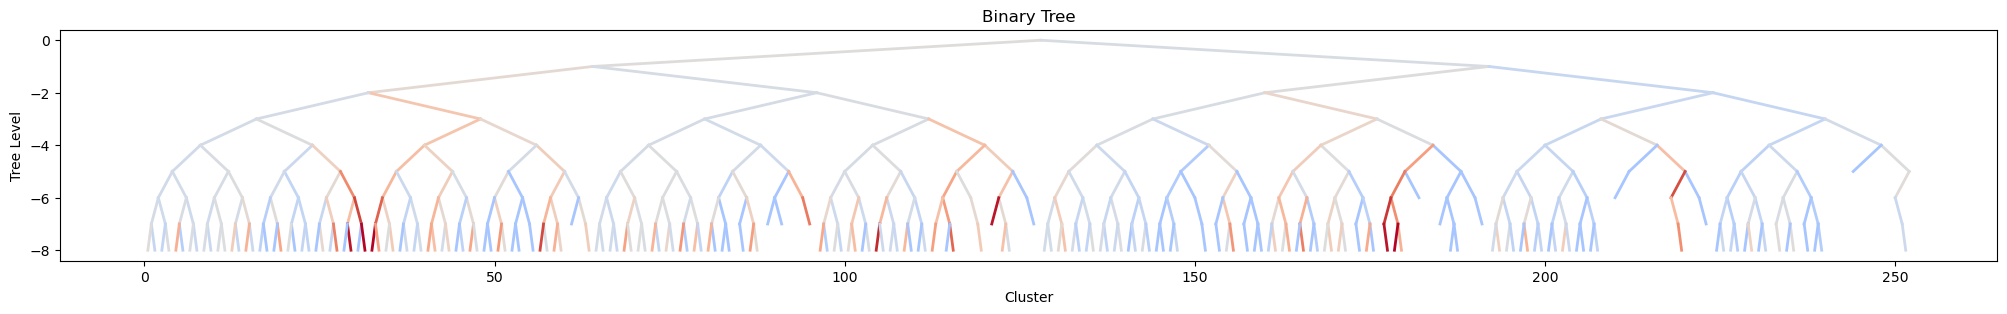

key            []
depth           0
mean     0.035092
ci_l     0.032797
ci_h     0.037496
count       41120
z             0.0
p             1.0
Name: 0, dtype: object


,key,depth,mean,ci_l,ci_h,count,z,p,fdr_p
168982,"[False, False, True, False, False, False, Fals...",23,0.933333,0.598408,0.999666,15,18.817681,5.410094e-79,3.261053e-76
140755,"[False, False, True, False, False, False, Fals...",22,0.894737,0.596321,0.994419,19,20.248473,3.664206e-91,2.524206e-88
69471,"[False, False, True, False, False, False, Fals...",19,0.818182,0.591287,0.950766,33,24.228956,1.102170e-129,1.062971e-126
115238,"[False, False, True, False, False, False, Fals...",21,0.812500,0.580522,0.949134,32,23.693687,4.188656e-124,3.366406e-121
51125,"[False, False, True, False, False, False, Fals...",18,0.670213,0.533708,0.788966,94,32.780638,1.111629e-235,5.360471e-232
35852,"[False, False, True, False, False, False, Fals...",17,0.663158,0.527154,0.782330,95,32.588470,5.974174e-233,1.440426e-229
23976,"[False, False, True, False, False, False, Fals...",16,0.659794,0.525168,0.778277,97,32.742853,3.837704e-235,1.233739e-231
199281,"[False, False, True, False, False, False, Fals...",24,0.916667,0.522974,0.999582,12,16.535179,2.047693e-61,8.228613e-59
15550,"[False, False, True, False, False, False, Fals...",15,0.627451,0.495540,0.747129,102,31.837718,1.947051e-222,3.129675e-219
115580,"[False, False, True, False, False, False, Fals...",21,0.660377,0.474943,0.816259,53,24.453645,4.602631e-132,4.932155e-129


In [9]:
#get clusters of molecules most associated with inhibiting HIV replication, plot tree, this is a bit slow
clusters = make_binary_plot(encodings).sort_values("ci_l", ascending=False)
clusters[:10]

## Get the best cluster

In [10]:
#get the node associated with the best cluster, defined as a T/F traversal of the tree
target_node_vector = torch.tensor(clusters.iloc[0].key).float()

## Generate roughly 100 molecules which are part of this cluster
### This function generates molecules conditioned on the embedding and then checks to make sure that they match it at the end

In [11]:
#Generate roughly 100 molecules which are part of the best cluster
#Don't try without a GPU
possible_solutions = []
while len(possible_solutions) < 100:
    generated_molecules = model.generate_molecules(target_node_vector, batch_size=128, evaluate_after_n_tokens=128, temperature=1, topk=500, topp=0.95)
    possible_solutions += generated_molecules
    possible_solutions = list(set(possible_solutions))
    print(f"{len(possible_solutions)} total molecules found so far")

#scramble the order since some were generated together as part of the same root
possible_solutions = list(pd.Series(possible_solutions).sample(frac=1))

Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

5 possibly valid sequences
5 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

4 possibly valid sequences
9 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

2 possibly valid sequences
11 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

7 possibly valid sequences
18 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

7 possibly valid sequences
25 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

3 possibly valid sequences
28 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

6 possibly valid sequences
41 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

11 possibly valid sequences
53 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

7 possibly valid sequences
60 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

6 possibly valid sequences
66 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

2 possibly valid sequences
68 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

7 possibly valid sequences
75 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

5 possibly valid sequences
80 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

3 possibly valid sequences
83 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

4 possibly valid sequences
86 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


[23:35:32] SMILES Parse Error: extra open parentheses while parsing: O=S(=O)(c1ccc(-c2cc(Nc3ccc(S([O-])(=O)=O)cc3)c(N=C3C=CC(=[N+](c4ccc(N=Cc5c(S(=O)(=O)[O-])cc(S(=O)(=O)CCCC)cc5)c5ccc(S(=O)(=O)[O-])cc5)c5c(S(=O)(=O)[O-])cc(S(=O)(=O)[O-])cc53)cc2)cc1)[O-]
[23:35:32] SMILES Parse Error: check for mistakes around position 8:
[23:35:32] O=S(=O)(c1ccc(-c2cc(Nc3ccc(S([O-])(=O)=O)
[23:35:32] ~~~~~~~^
[23:35:32] SMILES Parse Error: Failed parsing SMILES 'O=S(=O)(c1ccc(-c2cc(Nc3ccc(S([O-])(=O)=O)cc3)c(N=C3C=CC(=[N+](c4ccc(N=Cc5c(S(=O)(=O)[O-])cc(S(=O)(=O)CCCC)cc5)c5ccc(S(=O)(=O)[O-])cc5)c5c(S(=O)(=O)[O-])cc(S(=O)(=O)[O-])cc53)cc2)cc1)[O-]' for input: 'O=S(=O)(c1ccc(-c2cc(Nc3ccc(S([O-])(=O)=O)cc3)c(N=C3C=CC(=[N+](c4ccc(N=Cc5c(S(=O)(=O)[O-])cc(S(=O)(=O)CCCC)cc5)c5ccc(S(=O)(=O)[O-])cc5)c5c(S(=O)(=O)[O-])cc(S(=O)(=O)[O-])cc53)cc2)cc1)[O-]'
[23:35:32] Can't kekulize mol.  Unkekulized atoms: 28 61 62 67 68 73 74
[23:35:32] SMILES Parse Error: extra open parentheses while parsing: O=S(=O)(c1ccc(-c2cc

  0%|          | 0/256 [00:00<?, ?it/s]

7 possibly valid sequences
96 total molecules found so far
Generating samples with temp of 1 topk of 500 and topp of 0.95


  0%|          | 0/256 [00:00<?, ?it/s]

9 possibly valid sequences
105 total molecules found so far


In [12]:
#shows molecules plotted in a grid
def show_molecule_grid(smiles, rows, cols):
    """
    Display a grid of molecule images.
    
    Parameters:
        mols (list): List of molecule images (e.g., PIL Images from RDKit).
        rows (int): Number of rows in the grid.
        cols (int): Number of columns in the grid.
    """
    #make images
    mols = []
    for s in smiles:
        m = MolFromSmiles(s)
        mols.append(Draw.MolToImage(m))
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
    
    # In case rows*cols == 1, axes won't be a list, so we ensure it's iterable.
    if rows * cols == 1:
        axes = [axes]
    else:
        axes = axes.flatten()

    # Loop over each grid cell and display the molecule image if available.
    for i in range(rows * cols):
        ax = axes[i]
        if i < len(mols):
            ax.imshow(mols[i])
        ax.axis('off')  # Hide the axes ticks and labels.
    
    plt.tight_layout()
    plt.show()

## Molecules which are highly likely to inhibit HIV replication
### We can see obvious similarities between molecules in this cluster

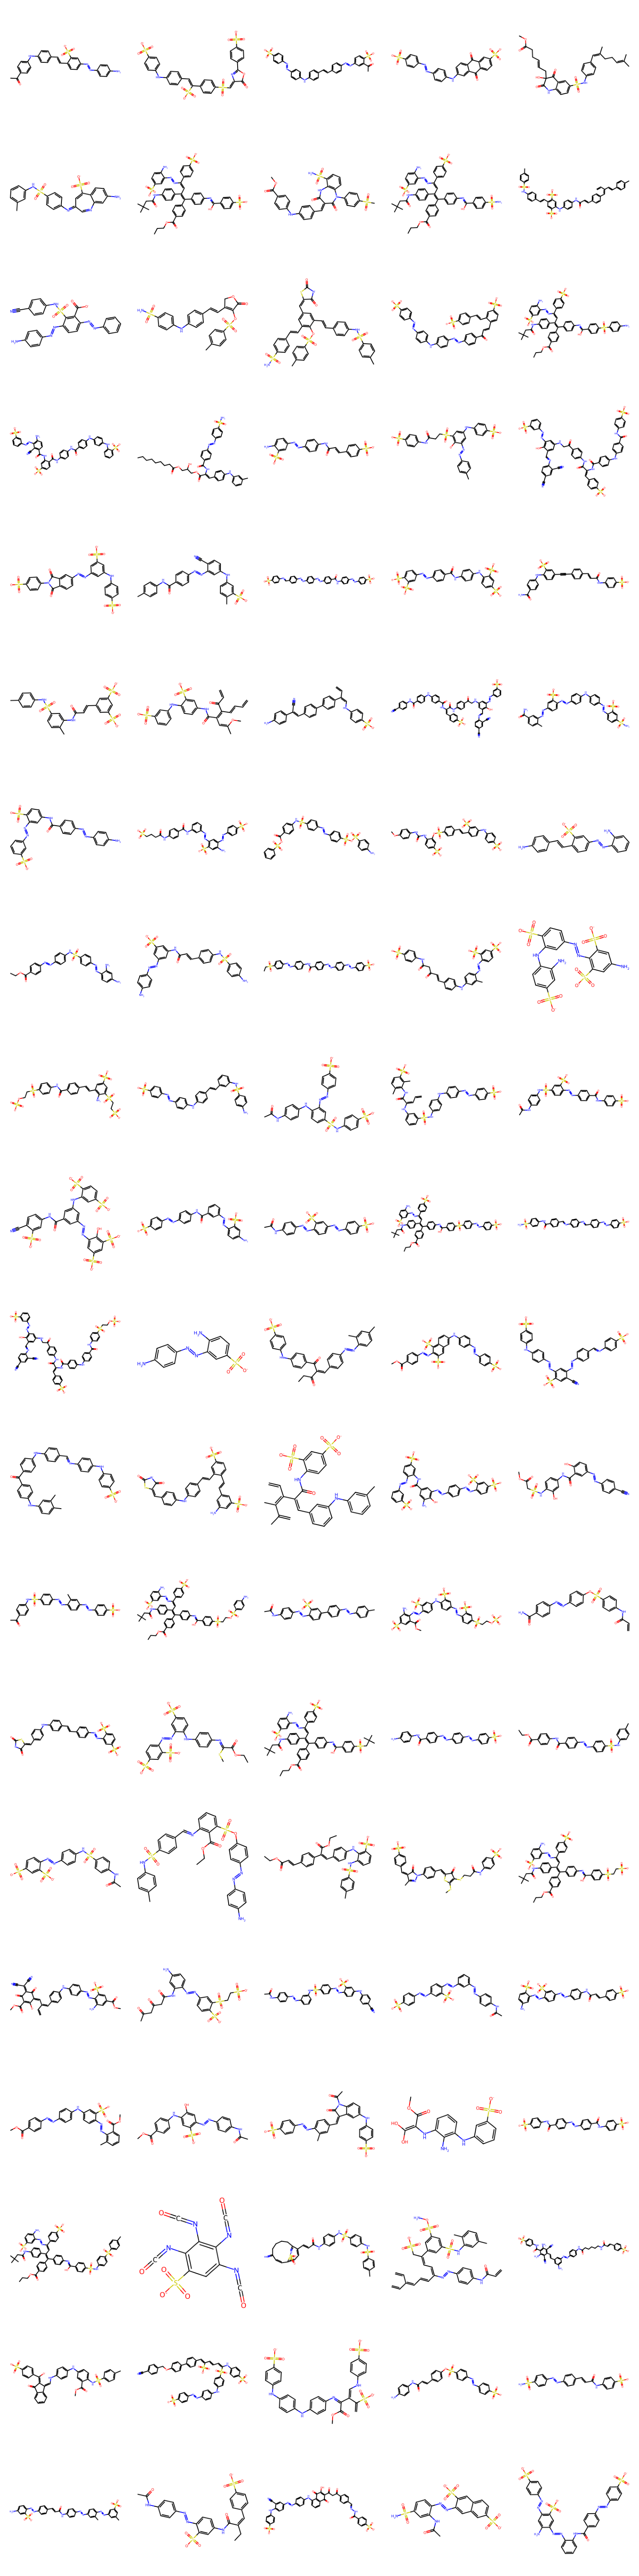

In [13]:
show_molecule_grid(possible_solutions, 20, 5)